In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('../datasets/derby-10.5.1.1.csv')
df = df.drop(columns=['HeuBug', 'HeuBugCount', 'RealBugCount'])

### Split Train/Test 80/20

In [2]:
# split train and test
from sklearn.model_selection import train_test_split

X = df.drop(columns=['RealBug'])
y = df['RealBug']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_numeric = X_train.select_dtypes(include=['float64', 'int64'])

In [3]:
print(X_train.shape)
print(X_test.shape)

(2164, 66)
(541, 66)


## Balanceo de clases usando HCBOU

### Configuración de hiperparámetros HCBOU

In [4]:
import sys
sys.path.append('../utils')

%load_ext autoreload
%autoreload 2
from hcbou import hcbou_balance, get_recommended_params

print("="*50)

# Obtener parámetros recomendados para nuestro dataset
recommended_params = get_recommended_params(X_train_numeric, y_train, scenario='binary_classification')
print(f"Parámetros recomendados: {recommended_params}")

X_train_balanced, y_train_balanced = hcbou_balance(
    X_train_numeric, 
    y_train,
    **recommended_params,
    random_state=42,
    verbose=True
)

Parámetros recomendados: {'max_clusters_maj': 8, 'max_clusters_min': 6, 'k_smote': 3, 'min_cluster_obs': 5}
🚀 HCBOU BALANCING PIPELINE
Original distribution:
  Majority class (False): 1858 samples
  Minority class (True): 306 samples
  Imbalance ratio: 1:6.07

📉 Step 1: Majority Class Undersampling
----------------------------------------
Applying majority class undersampling...
Majority class: 1858 -> 1082 samples
Reduction: 58.2%

📈 Step 2: Minority Class Clustering & SMOTE
---------------------------------------------
Finding optimal clusters for minority class...
No valid clusters found. Using single cluster.
Applying SMOTE balancing to minority class...
Cluster distribution: {0: 306}
Cluster weights: {0: 1.0}
Cluster 0: 306 -> 1082 samples
Minority class: 306 -> 1082 samples
Change: 353.6%

🔄 Step 3: Combining Balanced Classes
-----------------------------------

✅ HCBOU BALANCING COMPLETED
Final distribution:
  Class False: 1082 samples
  Class True: 1082 samples
Total samples: 2

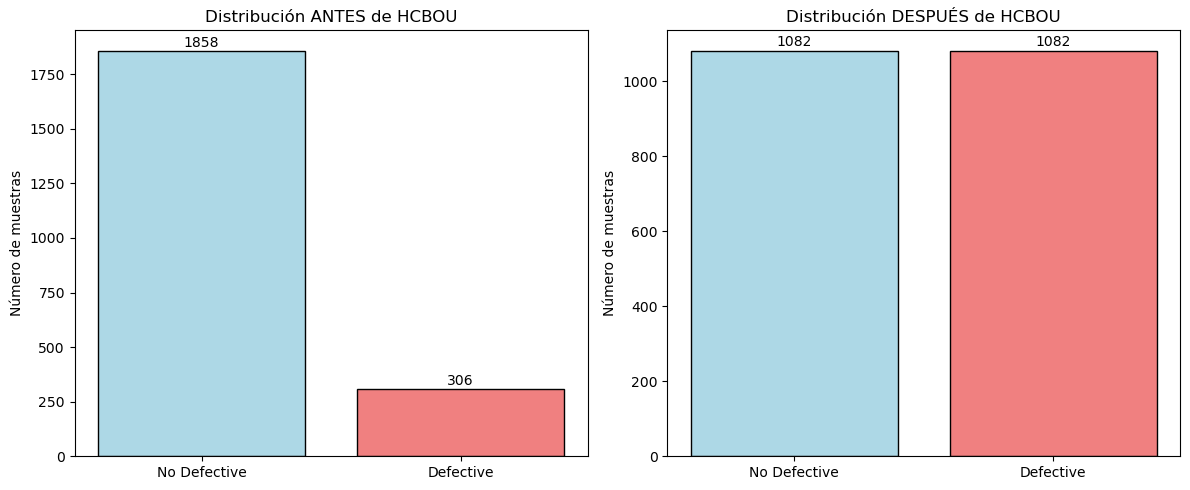


Verificación de calidad de datos balanceados:
Valores nulos en X_train_balanced: 0
Valores infinitos en X_train_balanced: 0
Shape final X_train_balanced: (2164, 65)
Shape final y_train_balanced: (2164,)


In [5]:
# Visualización de la distribución antes y después del balanceo
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Antes del balanceo
before_counts = y_train.value_counts().sort_index()
bars1 = ax1.bar(['No Defective', 'Defective'], before_counts.values, 
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax1.set_title('Distribución ANTES de HCBOU')
ax1.set_ylabel('Número de muestras')
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

# Después del balanceo
after_counts = y_train_balanced.value_counts().sort_index()
bars2 = ax2.bar(['No Defective', 'Defective'], after_counts.values,
                color=['lightblue', 'lightcoral'], edgecolor='black')
ax2.set_title('Distribución DESPUÉS de HCBOU')
ax2.set_ylabel('Número de muestras')
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Verificar que no hay valores nulos en los datos balanceados
print(f"\nVerificación de calidad de datos balanceados:")
print(f"Valores nulos en X_train_balanced: {X_train_balanced.isnull().sum().sum()}")
print(f"Valores infinitos en X_train_balanced: {np.isinf(X_train_balanced.values).sum()}")
print(f"Shape final X_train_balanced: {X_train_balanced.shape}")
print(f"Shape final y_train_balanced: {y_train_balanced.shape}")

### Normalización

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_balanced_scaled = pd.DataFrame(scaler.fit_transform(X_train_balanced), columns=X_train_balanced.columns, index=X_train_balanced.index)

In [7]:
X_train_balanced.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,...,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.000000,2164.0,2164.000000,2164.000000,2164.000000
mean,3.145564,16.211183,627.901109,8.068854,1.946396,1.135860,3.431146,57.767098,2.221349,27.328558,...,0.364603,0.212569,22.972736,4.085028,0.856858,0.248095,0.0,1.610444,0.212569,1.672828
std,8.044581,44.186009,929.493172,10.257768,5.194941,0.647216,12.785993,96.210829,1.873850,78.477854,...,1.020667,0.457242,116.078794,20.528031,0.147586,0.387718,0.0,0.861839,0.457242,2.098187
min,0.000000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.227656,0.000000,0.0,1.000000,0.000000,0.000000
25%,0.000000,6.000000,136.000000,2.000000,0.000000,1.000000,0.000000,8.000000,1.000000,10.750000,...,0.000000,0.000000,0.000000,0.000000,0.796044,0.000000,0.0,1.000000,0.000000,0.000000
50%,0.000000,10.000000,272.000000,5.000000,0.000000,1.000000,0.000000,23.000000,2.000000,18.000000,...,0.000000,0.000000,0.000000,0.000000,0.906667,0.000000,0.0,1.000000,0.000000,1.000000
75%,3.000000,18.000000,720.000000,10.000000,1.000000,1.000000,2.000000,65.000000,3.000000,29.000000,...,0.000000,0.000000,4.000000,0.000000,0.966889,0.500000,0.0,2.000000,0.000000,2.000000
max,155.000000,895.000000,10134.000000,82.000000,87.000000,10.000000,324.000000,1285.000000,21.000000,1679.000000,...,20.000000,4.000000,3487.000000,334.000000,1.000000,1.000000,0.0,7.000000,4.000000,15.000000


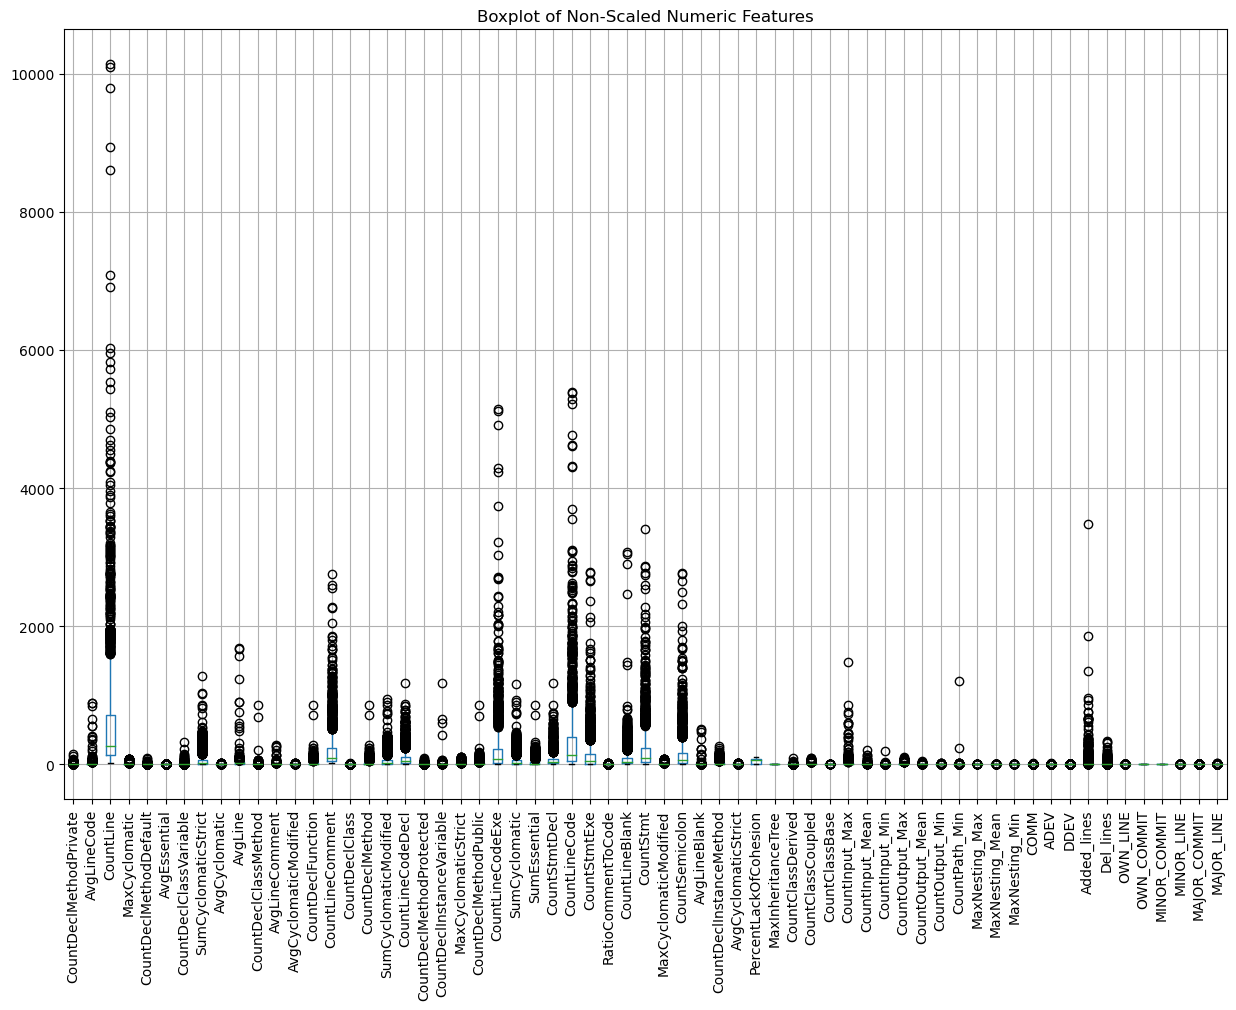

In [8]:
plt.figure(figsize=(15, 10))
X_train_balanced.drop(columns=['CountPath_Max', 'CountPath_Mean']).boxplot()
plt.title('Boxplot of Non-Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()

In [9]:
X_train_balanced_scaled.describe()

,CountDeclMethodPrivate,AvgLineCode,CountLine,MaxCyclomatic,CountDeclMethodDefault,AvgEssential,CountDeclClassVariable,SumCyclomaticStrict,AvgCyclomatic,AvgLine,...,ADEV,DDEV,Added_lines,Del_lines,OWN_LINE,OWN_COMMIT,MINOR_COMMIT,MINOR_LINE,MAJOR_COMMIT,MAJOR_LINE
count,2164.000000,2.164000e+03,2.164000e+03,2.164000e+03,2164.000000,2.164000e+03,2.164000e+03,2.164000e+03,2164.000000,2.164000e+03,...,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2.164000e+03,2164.0,2.164000e+03,2.164000e+03,2.164000e+03
mean,0.000000,6.566938e-18,2.626775e-17,2.626775e-17,0.000000,-6.566938e-17,9.850408e-18,5.253551e-17,0.000000,1.313388e-17,...,-5.253551e-17,-6.566938e-18,3.283469e-18,1.313388e-17,-3.940163e-16,-2.626775e-17,0.0,1.576065e-16,-6.566938e-18,-7.880326e-17
std,1.000231,1.000231e+00,1.000231e+00,1.000231e+00,1.000231,1.000231e+00,1.000231e+00,1.000231e+00,1.000231,1.000231e+00,...,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,1.000231e+00,0.0,1.000231e+00,1.000231e+00,1.000231e+00
min,-0.391107,-3.669698e-01,-6.509364e-01,-7.867910e-01,-0.374758,-1.755397e+00,-2.684140e-01,-6.005608e-01,-1.185721,-3.483132e-01,...,-3.573025e-01,-4.650024e-01,-1.979521e-01,-1.990435e-01,-4.264291e+00,-6.400321e-01,0.0,-7.084672e-01,-4.650024e-01,-7.974576e-01
25%,-0.391107,-2.311488e-01,-5.293367e-01,-5.917717e-01,-0.374758,-2.099621e-01,-2.684140e-01,-5.173908e-01,-0.651937,-2.113002e-01,...,-3.573025e-01,-4.650024e-01,-1.979521e-01,-1.990435e-01,-4.121570e-01,-6.400321e-01,0.0,-7.084672e-01,-4.650024e-01,-7.974576e-01
50%,-0.391107,-1.406015e-01,-3.829865e-01,-2.992428e-01,-0.374758,-2.099621e-01,-2.684140e-01,-3.614472e-01,-0.118153,-1.188961e-01,...,-3.573025e-01,-4.650024e-01,-1.979521e-01,-1.990435e-01,3.375657e-01,-6.400321e-01,0.0,-7.084672e-01,-4.650024e-01,-3.207454e-01
75%,-0.018099,4.049315e-02,9.910797e-02,1.883053e-01,-0.182218,-2.099621e-01,-1.119566e-01,7.519501e-02,0.415631,2.130318e-02,...,-3.573025e-01,-4.650024e-01,-1.634848e-01,-1.990435e-01,7.457100e-01,6.498614e-01,0.0,4.521104e-01,-4.650024e-01,1.559668e-01
max,18.880976,1.989299e+01,1.022955e+01,7.208999e+00,16.376174,1.369895e+01,2.507767e+01,1.275861e+01,10.023742,2.105120e+01,...,1.924226e+01,8.285130e+00,2.984893e+01,1.607515e+01,9.701134e-01,1.939755e+00,0.0,6.254999e+00,8.285130e+00,6.353226e+00


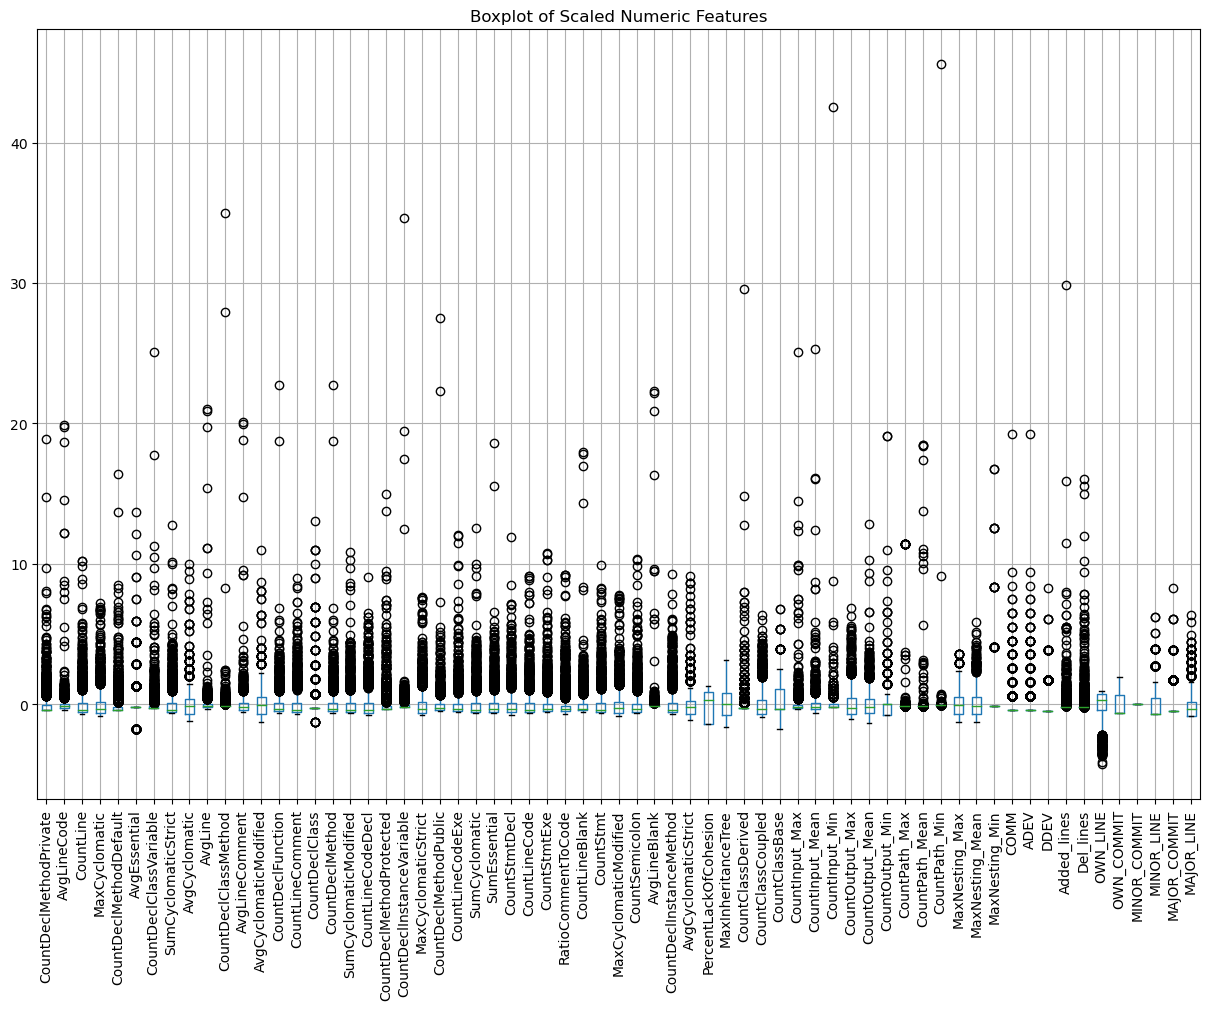

In [10]:
plt.figure(figsize=(15, 10))
X_train_balanced_scaled.boxplot()
plt.title('Boxplot of Scaled Numeric Features')
plt.xticks(rotation=90)
plt.show()